# Stationarity

In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(0) # Reproducibility

---

## Stationary Time Series

#### Things to check in practice.

1. Constant mean (no trend).
2. Constant variance
3. Constant(relatively) autocorrelation: correlation between two time steps **only depends on the shift (lag) between two time steps, instead of absolute positions**
4. No periodic component

In [3]:
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

In [4]:
time = np.arange(200)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

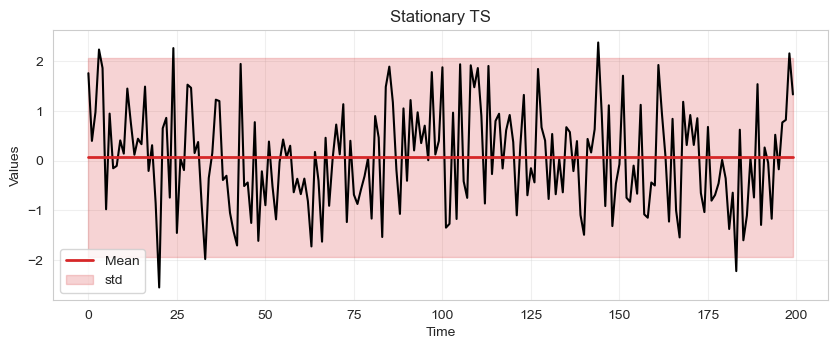

In [5]:
ax = run_sequence_plot(time, stationary, title="Stationary TS")
ax.plot(time, np.ones_like(time)*np.mean(stationary), linewidth=2, color='tab:red', label='Mean')
ax.fill_between(time, np.ones_like(time)*(stationary.mean()-1.96*stationary.std()),
                np.ones_like(time)*(stationary.mean()+1.96*stationary.std()), color='tab:red', alpha=0.2, label='std')
plt.legend()

#### Autocorrelation
- Autocorrelation measures how much the current time series measurement is correlated with a past measurement.
- For example, today's temperature is often highly correlated with yesterday's temperature.
- To discuss these things we must introduce the idea of a *lag*, i.e., a delay.

**Example: constant autocorrelation**

- E.g., the correlation between today's temperature and tomorrow's temperature is roughly the same as the correlation between the temperature 30 days ago and 29 days ago.

#### White noise (stationary)

- We already looked at this time series and conclude that mean and variance are constant and there is no seasonal component.
- In addition, since the value of each time step is drawn independently, there is no correlation.

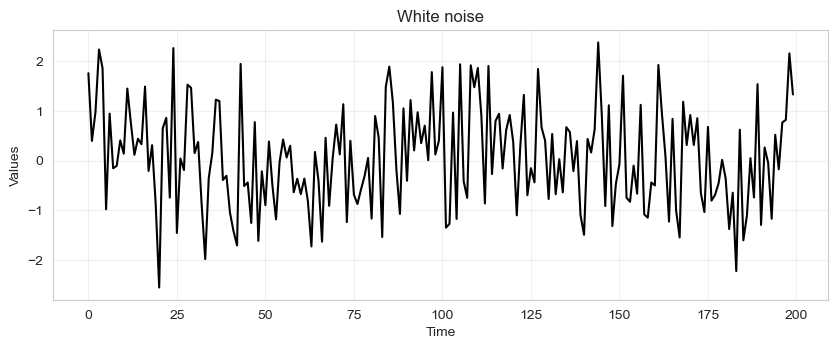

In [6]:
run_sequence_plot(time, stationary, title="White noise");

#### Random walk (non-stationary)

- The random walk is one of the most important nonstationary time series.
- It is defined as:

$$X(t) = X(t-1) + \epsilon_t$$  

- where $\epsilon_t$ are called *innovations* and are iid, e.g., $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$.
- Let's create a random walk.

In [7]:
# seed to start series
seed = 3.14

# Random Walk
rand_walk = np.empty_like(time, dtype='float')
for t in time:
    rand_walk[t] = seed + np.random.normal(loc=0, scale=2.5, size=1)[0]
    seed = rand_walk[t]

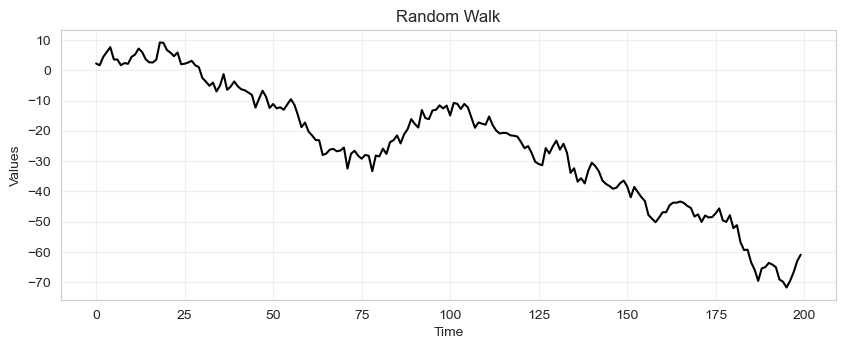

In [8]:
run_sequence_plot(time, rand_walk, title="Random Walk");

#### Time series with trend (non-stationary)

In [9]:
trend = (time * 2.75) + stationary

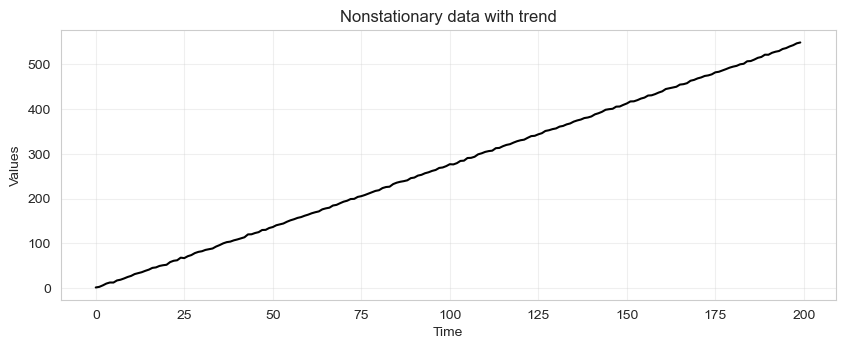

In [10]:
run_sequence_plot(time, trend, title="Nonstationary data with trend");

#### Heteroscedastic time series (non-stationary)

In [11]:
level_1 = np.random.normal(loc=0, scale=1.0, size = 100)
level_2 = np.random.normal(loc=0, scale=10.0, size = 100)
heteroscedasticity = np.append(level_1, level_2)

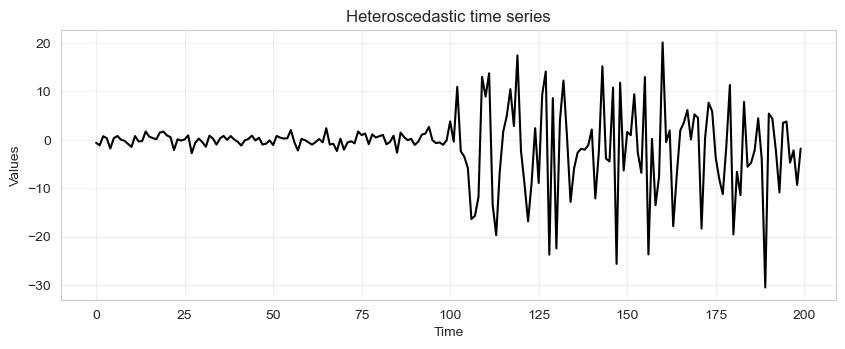

In [12]:
run_sequence_plot(time, heteroscedasticity, title="Heteroscedastic time series");

#### Time series with seasonality (non-stationary)

In [13]:
seasonality = 20 + np.sin(2*np.pi*time/12)*20

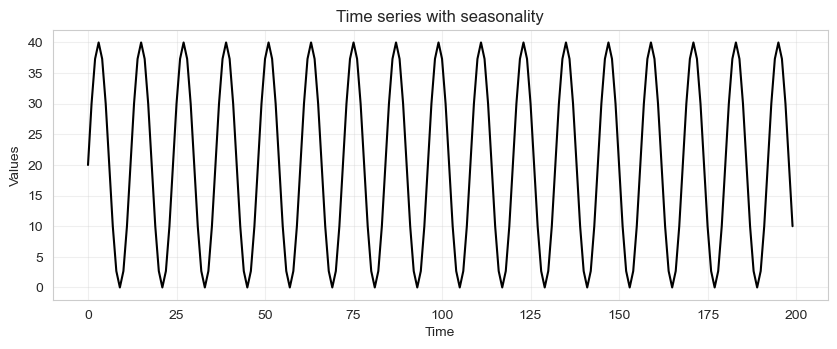

In [14]:
run_sequence_plot(time, seasonality, title="Time series with seasonality");

### How to deal with autocorrelation: Autocorrelation Function (ACF)
  - The ACF measures the correlation of a time series with its own lagged values

  $$ ACF(k) = \frac{\mathbb{E}[(X(t) - \mu)(X(t-k) - \mu)]}{\sigma^2} $$

  - where:
    - $k$ is the lag number.
    - $X(t)$ is the value at time  $t$.
    - $\mu$ is the mean of the series.
    - $\sigma^2$ is the variance of the series.
  - Values close to 1 or -1 indicate strong correlation, while values near 0 indicate weak correlation.

In [20]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from ipynb.fs.full.stationarity import run_sequence_plot
np.random.seed(0) # For reproducibility

#### Constant autocorrelation VS Non-constant autocorrelation

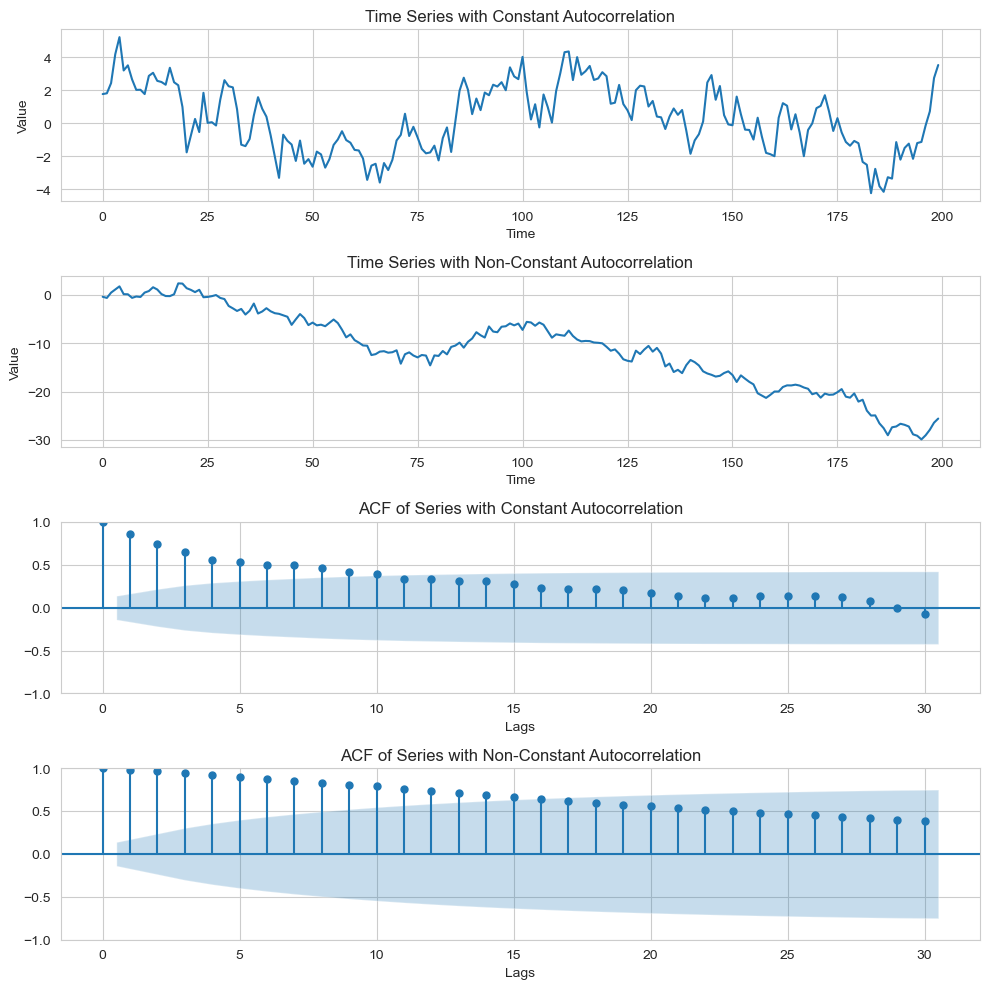

In [16]:
# Example 1: Strong constant autocorrelation (stationary process with high persistence)
n = 200
constant_corr_series_obvious = np.random.normal(0, 1, n)
for i in range(1, n):
    constant_corr_series_obvious[i] += 0.8 * constant_corr_series_obvious[i - 1]  # strong persistence

# Example 2: Strong non-constant autocorrelation (changing correlation with a clear trend)
non_constant_corr_series_obvious = np.cumsum(np.random.normal(0, 1, n))  # clear non-stationary random walk

# Plotting the time series
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# Plot strong constant autocorrelation series
axs[0].plot(constant_corr_series_obvious)
axs[0].set_title("Time Series with Constant Autocorrelation")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Value")

# Plot strong non-constant autocorrelation series
axs[1].plot(non_constant_corr_series_obvious)
axs[1].set_title("Time Series with Non-Constant Autocorrelation")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Value")

# ACF plots
plot_acf(constant_corr_series_obvious, ax=axs[2], lags=30)
axs[2].set_title("ACF of Series with Constant Autocorrelation")
axs[2].set_xlabel("Lags")

plot_acf(non_constant_corr_series_obvious, ax=axs[3], lags=30)
axs[3].set_title("ACF of Series with Non-Constant Autocorrelation")
axs[3].set_xlabel("Lags")

plt.tight_layout()
plt.show()

- **stationary ACF will decay to zero quickly** after a few lags but non-stationary one will not

#### Constant autocorrelation VS Seasonality

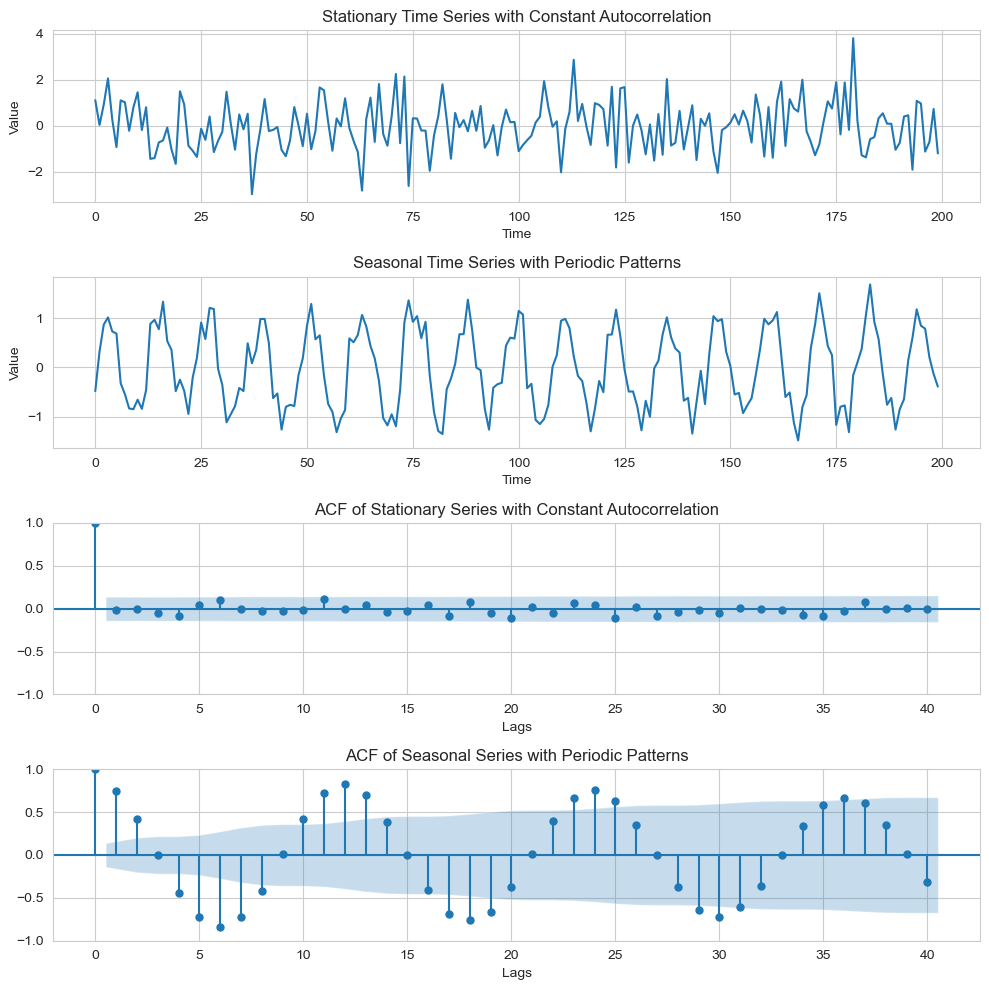

In [17]:
# Example 1: Constant autocorrelation (stationary process)
np.random.seed(42)
n = 200
stationary_series = np.random.normal(0, 1, n) + 0.5 * np.roll(np.random.normal(0, 1, n), 1)

# Example 2: Seasonal time series
seasonal_period = 12
seasonal_component = np.sin(2 * np.pi * np.arange(n) / seasonal_period)
seasonal_series = seasonal_component + np.random.normal(0, 0.3, n)

# Plotting the time series
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# Plot stationary series with constant autocorrelation
axs[0].plot(stationary_series)
axs[0].set_title("Stationary Time Series with Constant Autocorrelation")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Value")

# Plot seasonal time series
axs[1].plot(seasonal_series)
axs[1].set_title("Seasonal Time Series with Periodic Patterns")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Value")

# ACF plots
plot_acf(stationary_series, ax=axs[2], lags=40)
axs[2].set_title("ACF of Stationary Series with Constant Autocorrelation")
axs[2].set_xlabel("Lags")

plot_acf(seasonal_series, ax=axs[3], lags=40)
axs[3].set_title("ACF of Seasonal Series with Periodic Patterns")
axs[3].set_xlabel("Lags")

plt.tight_layout()
plt.show()

- **stationary ACF will decay to zero quickly** after a few lags but seasonal time series will keep its periodicity

### Limitations and Considerations
1. Correlation functions only measure *linear* relationships.
2. ACF measures both direct and *indirect correlations* between lags.
    - A strong correlation at higher lags could be a result of the accumulation of correlations at shorter lags.

### The Partial Autocorrelation Function (PACF)

- PACF addresses the 4th limitation of ACF by **removing the influence of correlations at shorter lags**, useful for **AR**
- High PACF at lag $k$ indicates a strong partial correlation with the $k$-th lag, not accounted for by correlations at lower lags.


- PACF of lag $k$ is sometimes denoted as $\phi_{kk}$:

$$\phi_{kk} = \text{Corr}\big(X(t) - \hat{X}(t), X(t-k) - \hat{X}(t-k)\big)$$

- where:
    - $\hat{X}(t)$ is the predicted value of $X(t)$ based on all the values up to $t-1$.
    - $\hat{X}(t-k)$ is the predicted value of $X(t-k)$ based on all the values up to $t-k-1$.

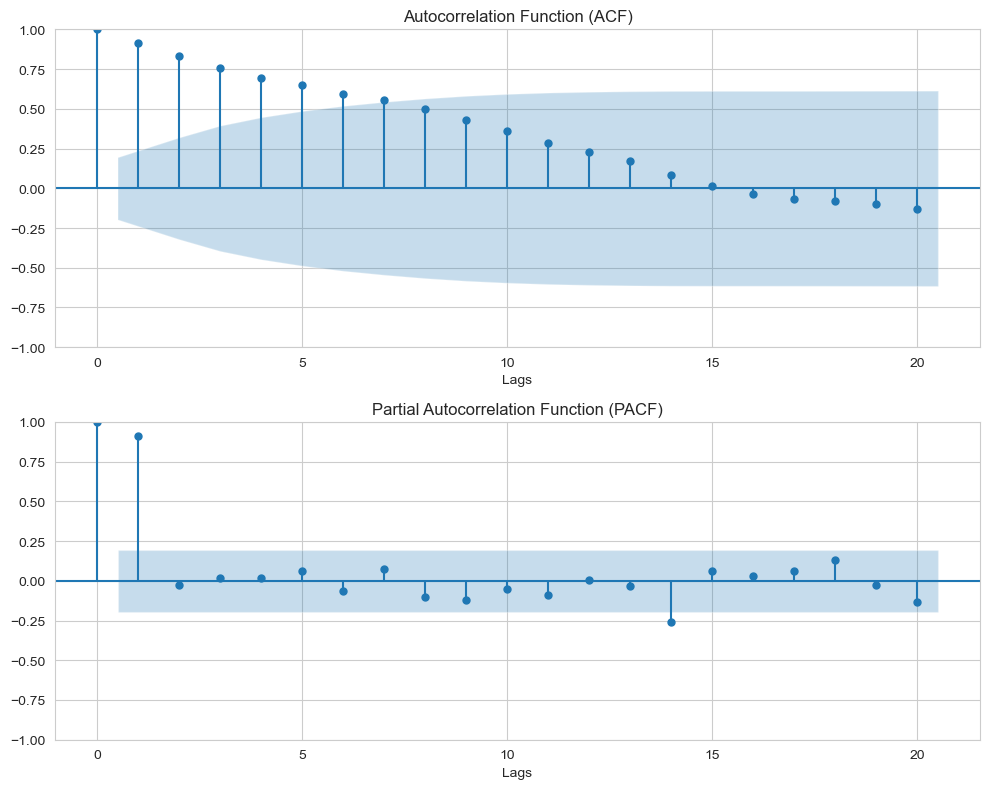

In [18]:
n = 100
time_series = np.cumsum(np.random.randn(n))  # random walk series

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot
plot_acf(time_series, ax=ax[0], lags=20)
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].set_xlabel("Lags")

# PACF plot
plot_pacf(time_series, ax=ax[1], lags=20)
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].set_xlabel("Lags")

plt.tight_layout()
plt.show()

In the PACF above, significant lag is 1

**PACF can be applied to both stationary and non-stationary time series, but applying to stationary series is more meaningful (especially for Autoregressive model)**

## Detecting stationarity
### Augmented Dickey-Fuller Test

- This is a statistical procedure to determine whether a time series is stationary or not.
- We will discuss more details about the test in the next lectures
- For now, that's what we need to know:
    1. **Null hypothesis:** $H_0$: the series is nonstationary.
    2. **Alternative hypothesis:** $H_A$: the series is stationary.

Example: $p = 0.0001 \rightarrow$ reject $H_0 \rightarrow$ the time series is stationary

Example: $p = 0.43 \rightarrow$ fail to reject $H_0 \rightarrow$ the time series is non-stationary

In [19]:
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(stationary)
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue}")
print(f"critical_values: {critical_values}")

ADF: -13.86
p-value: 6.840777685659985e-26
critical_values: {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}


- First, `adf` is the value of the test statistic.
- The more negative the value, the more confident we can be that the series is stationary.
- Here we see a negative value.
- That may not mean anything to you just yet but `pvalue` should.

### ADF may not work for seasonality detection